In [28]:
import pandas as pd
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pickle
import joblib
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from skimage.transform import resize

In [29]:
path_csv = "./ESC-50-master/meta/esc50.csv"

In [30]:
df = pd.read_csv(path_csv)

In [31]:
df

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A
...,...,...,...,...,...,...,...
1995,5-263831-B-6.wav,5,6,hen,False,263831,B
1996,5-263902-A-36.wav,5,36,vacuum_cleaner,False,263902,A
1997,5-51149-A-25.wav,5,25,footsteps,False,51149,A
1998,5-61635-A-8.wav,5,8,sheep,False,61635,A


In [32]:
category = ["crying_baby", "sneezing", "clapping", "breathing", "coughing", "footsteps", "laughing", "brushing_teeth", "snoring", "drinking_sipping"]

In [33]:
df = df.loc[df["category"].isin(category)]

In [34]:
df = df.reset_index(drop=True)

In [35]:
sample_num = 144
sr = 44100
max_size = 480
hop_length = 512
n_fft = 255
h = 128
n_mfcc = 128
epoch = 30
n_batch = 10

In [36]:
s = df.loc[sample_num,['filename']].values[0]
filename= f"./ESC-50-master/audio/{s}"
print(filename)

./ESC-50-master/audio/2-85292-A-24.wav


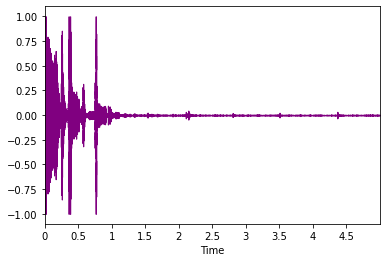

In [37]:
y, sr = librosa.load(filename, sr=sr)
librosa.display.waveplot(y, sr=sr, x_axis='time', color='purple',offset=0.0)

In [38]:
def padding(array, xx, yy):
    """
    :param array: numpy array
    :param xx: desired height
    :param yy: desirex width
    :return: padded array
    """

    h = array.shape[0]
    w = array.shape[1]

    a = (xx - h) // 2
    aa = xx - a - h

    b = (yy - w) // 2
    bb = yy - b - w

    return np.pad(array, pad_width=((a, aa), (b, bb)), mode='constant')

In [39]:
def generate_features(y_cut):
    stft = padding(np.abs(librosa.stft(y_cut, n_fft=n_fft, hop_length = hop_length)), h, max_size)
    MFCCs = padding(librosa.feature.mfcc(y_cut, n_fft=n_fft, hop_length = hop_length,n_mfcc=n_mfcc),h,max_size)
    spec_centroid = librosa.feature.spectral_centroid(y=y_cut, sr=sr)
    chroma_stft = librosa.feature.chroma_stft(y=y_cut, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y_cut, sr=sr)
    #Now the padding part
    image = np.array([padding(normalize(spec_bw),1, max_size)]).reshape(1,max_size)
    image = np.append(image,padding(normalize(spec_centroid),1, max_size), axis=0) 
    #repeat the padded spec_bw,spec_centroid and chroma stft until they are stft and MFCC-sized
    for i in range(0,9):
        image = np.append(image, padding(normalize(spec_bw),1, max_size), axis=0)
        image = np.append(image, padding(normalize(spec_centroid),1, max_size), axis=0)
        image = np.append(image, padding(normalize(chroma_stft),12, max_size), axis=0)
    image=np.dstack((image,np.abs(stft)))
    image=np.dstack((image,MFCCs))
    return image

In [40]:
spec_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
image = np.array([padding(normalize(spec_bw),1, max_size)]).reshape(1,max_size)
image = np.append(image,padding(normalize(spec_centroid),1, max_size), axis=0) 
for i in range(0,9):
    image = np.append(image, padding(normalize(spec_bw),1, max_size), axis=0)
    image = np.append(image, padding(normalize(spec_centroid),1, max_size), axis=0)
    image = np.append(image, padding(normalize(chroma_stft),12, max_size), axis=0)

In [41]:
image.shape

(128, 480)

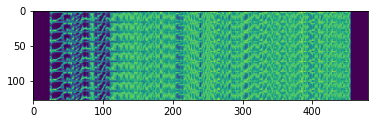

In [42]:
plt.imshow(image)

In [43]:
result = generate_features(y)

In [44]:
result.shape

(128, 480, 3)

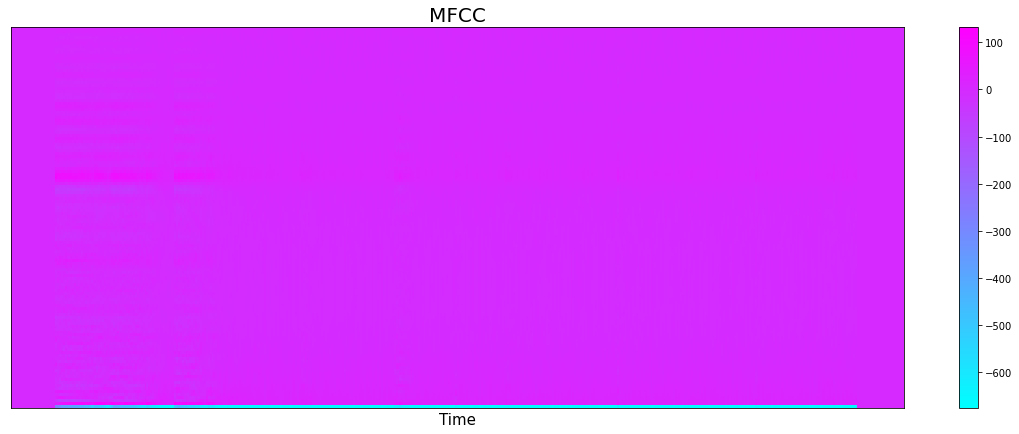

In [45]:
MFCCs = padding(librosa.feature.mfcc(y, n_fft=n_fft, hop_length=hop_length,n_mfcc=n_mfcc),h,max_size)
fig, ax = plt.subplots(figsize=(20,7))
librosa.display.specshow(MFCCs,sr=sr, cmap='cool')
ax.set_xlabel('Time', fontsize=15)
ax.set_title('MFCC', size=20)
plt.colorbar()
plt.show()

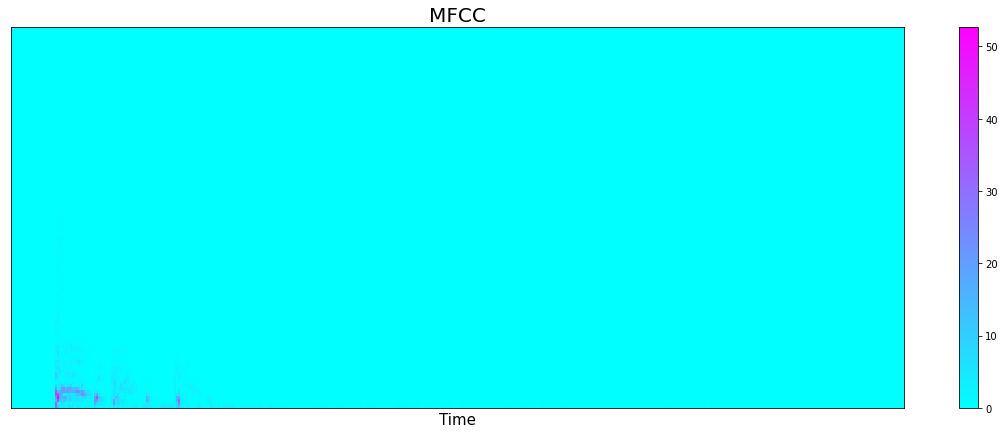

In [46]:
stft = padding(np.abs(librosa.stft(y, n_fft=n_fft, hop_length = hop_length)), h,max_size)
fig, ax = plt.subplots(figsize=(20,7))
librosa.display.specshow(stft,sr=sr, cmap='cool')
ax.set_xlabel('Time', fontsize=15)
ax.set_title('MFCC', size=20)
plt.colorbar()
plt.show()

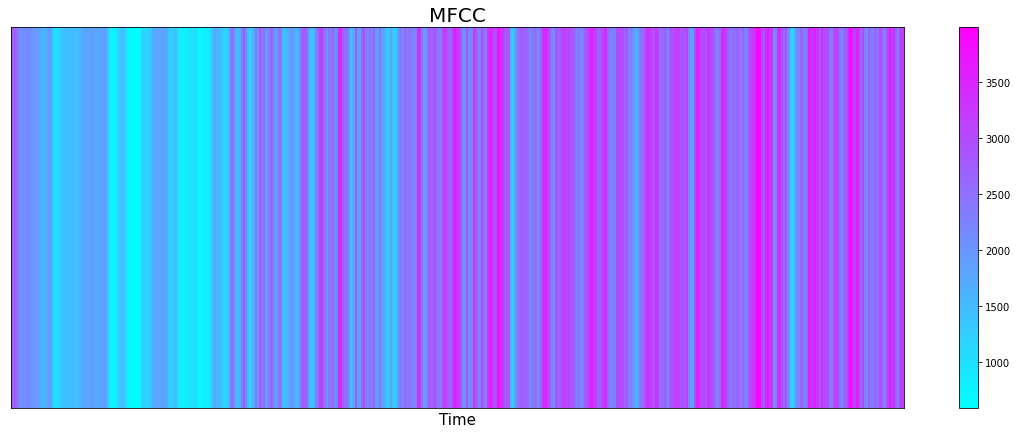

In [47]:
spec_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
fig, ax = plt.subplots(figsize=(20,7))
librosa.display.specshow(spec_centroid,sr=sr, cmap='cool')
ax.set_xlabel('Time', fontsize=15)
ax.set_title('MFCC', size=20)
plt.colorbar()
plt.show()

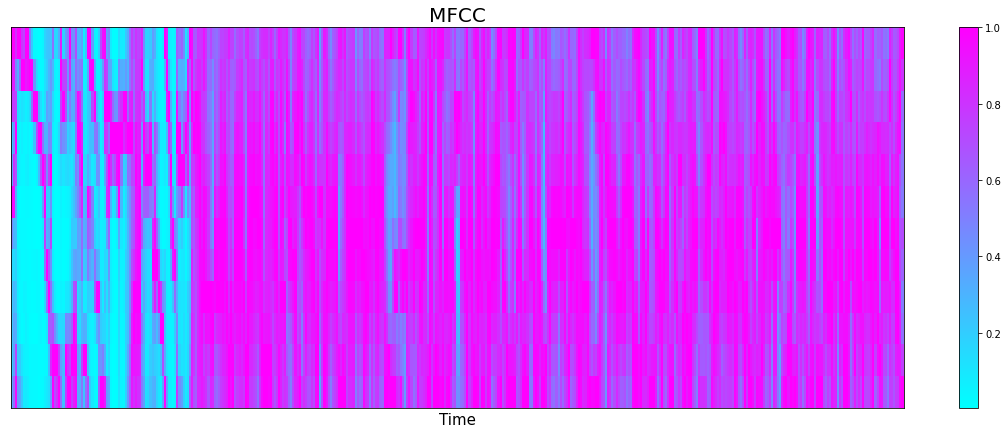

In [48]:
chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
fig, ax = plt.subplots(figsize=(20,7))
librosa.display.specshow(chroma_stft,sr=sr, cmap='cool')
ax.set_xlabel('Time', fontsize=15)
ax.set_title('MFCC', size=20)
plt.colorbar()
plt.show()

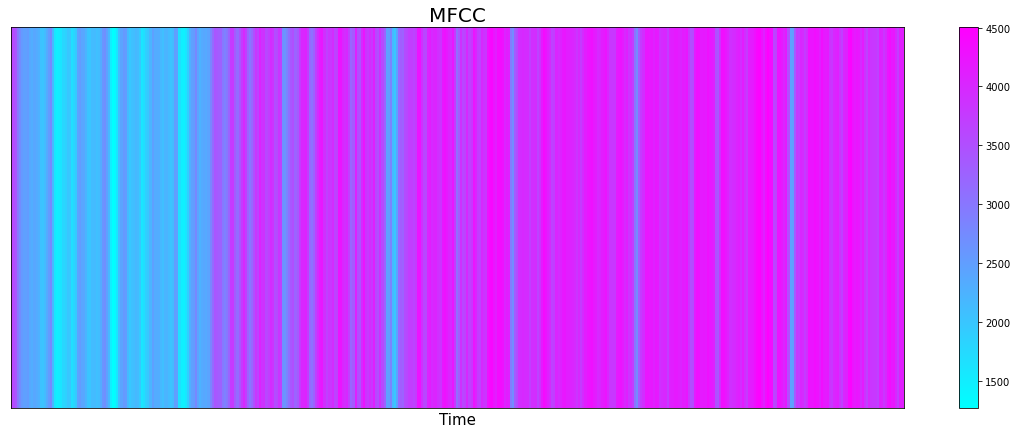

In [49]:
spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
fig, ax = plt.subplots(figsize=(20,7))
librosa.display.specshow(spec_bw,sr=sr, cmap='cool')
ax.set_xlabel('Time', fontsize=15)
ax.set_title('MFCC', size=20)
plt.colorbar()
plt.show()

In [50]:
def get_features(df_in, rs=None):   
    features=[]
    labels = []
    
    for index, row in df_in.iterrows():
        label = df.loc[index,['category']].values[0]
        s = df.loc[index,['filename']].values[0]
        filename = f"./ESC-50-master/audio/{s}" 
        y, sr = librosa.load(filename,sr=44100)
        data = generate_features(y)
        if not rs is None:
            data = resize(data, rs)
        features.append(data[np.newaxis,...])    
        labels.append(label)     
    output=np.concatenate(features,axis=0)     
    return(np.array(output), labels)

In [51]:
X, y = get_features(df, rs=(224,224))

In [52]:
enc = LabelEncoder()
enc.fit(y)
y = enc.transform(y)
n_classes = len(enc.classes_)

In [54]:
enc.classes_

array(['breathing', 'brushing_teeth', 'clapping', 'coughing',
       'crying_baby', 'drinking_sipping', 'footsteps', 'laughing',
       'sneezing', 'snoring'], dtype='<U16')

In [23]:
X.shape

(400, 224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


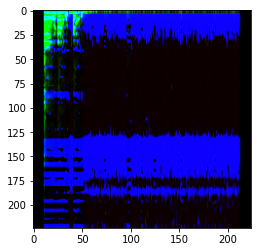

In [24]:
plt.imshow(X[144])

In [25]:
#Split twice to get the validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=123)
#Print the shapes
X_train.shape, X_test.shape, X_val.shape, len(y_train), len(y_test), len(y_val)

((225, 224, 224, 3), (100, 224, 224, 3), (75, 224, 224, 3), 225, 100, 75)

In [26]:
X_train = np.array((X_train-np.min(X_train))/(np.max(X_train)-np.min(X_train)))
X_test = np.array((X_test-np.min(X_test))/(np.max(X_test)-np.min(X_test)))
X_val = np.array((X_val-np.min(X_val))/(np.max(X_val)-np.min(X_val)))
X_train = X_train/np.std(X_train)
X_test = X_test/np.std(X_test)
X_val = X_val/np.std(X_val)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

# MODEL

In [27]:
#from tensorflow.keras.applications import VGG19
#from tensorflow.keras.applications import Xception
#from tensorflow.keras.applications import ResNet50
#from tensorflow.keras.applications import ResNet50V2
#from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

# Intento 1

In [28]:
baseModel = VGG16(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/VGG16/base-adam-VGG16-0.1.h5")

In [29]:
opt = tf.keras.optimizers.Adam(learning_rate=0.1)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [30]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 11s 263ms/step - loss: nan - accuracy: 0.0807 - val_loss: nan - val_accuracy: 0.0800
Epoch 2/30
23/23 [==============================] - 3s 139ms/step - loss: nan - accuracy: 0.1036 - val_loss: nan - val_accuracy: 0.0800
Epoch 3/30
23/23 [==============================] - 3s 139ms/step - loss: nan - accuracy: 0.1104 - val_loss: nan - val_accuracy: 0.0800
Epoch 4/30
23/23 [==============================] - 3s 139ms/step - loss: nan - accuracy: 0.0946 - val_loss: nan - val_accuracy: 0.0800
Epoch 5/30
23/23 [==============================] - 3s 140ms/step - loss: nan - accuracy: 0.0955 - val_loss: nan - val_accuracy: 0.0800
Epoch 6/30
23/23 [==============================] - 3s 139ms/step - loss: nan - accuracy: 0.1184 - val_loss: nan - val_accuracy: 0.0800
Epoch 7/30
23/23 [==============================] - 3s 140ms/step - loss: nan - accuracy: 0.1081 - val_loss: nan - val_accuracy: 0.0800
Epoch 8/30
23/23 [=============================

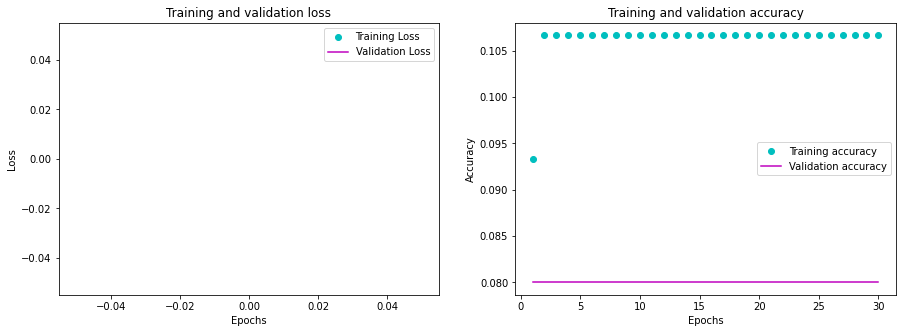

In [31]:
#Adapted from Deep Learning with Python by Francois Chollet, 2018
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [32]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 1s 432ms/step - loss: nan - accuracy: 0.1000
Confusion_matrix:  tf.Tensor(
[[10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]], shape=(10, 10), dtype=int32)


In [33]:
model.save("model/VGG16/fit-adam-VGG16-0.1.h5")

# Intento 2 

In [34]:
baseModel = VGG16(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/VGG16/base-adam-VGG16-0.01.h5")

In [35]:
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [36]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 4s 148ms/step - loss: 8772605162.7779 - accuracy: 0.0882 - val_loss: 361.9178 - val_accuracy: 0.1200
Epoch 2/30
23/23 [==============================] - 3s 141ms/step - loss: 382.0260 - accuracy: 0.0236 - val_loss: 54.1378 - val_accuracy: 0.0800
Epoch 3/30
23/23 [==============================] - 3s 141ms/step - loss: 23.9599 - accuracy: 0.0907 - val_loss: 2.3703 - val_accuracy: 0.0800
Epoch 4/30
23/23 [==============================] - 3s 140ms/step - loss: 2.3125 - accuracy: 0.1205 - val_loss: 2.3505 - val_accuracy: 0.0800
Epoch 5/30
23/23 [==============================] - 3s 140ms/step - loss: 2.3106 - accuracy: 0.1124 - val_loss: 2.3377 - val_accuracy: 0.0800
Epoch 6/30
23/23 [==============================] - 3s 141ms/step - loss: 2.3120 - accuracy: 0.0920 - val_loss: 2.3325 - val_accuracy: 0.0667
Epoch 7/30
23/23 [==============================] - 3s 140ms/step - loss: 2.3037 - accuracy: 0.0922 - val_loss: 2.3275 - val_accuracy

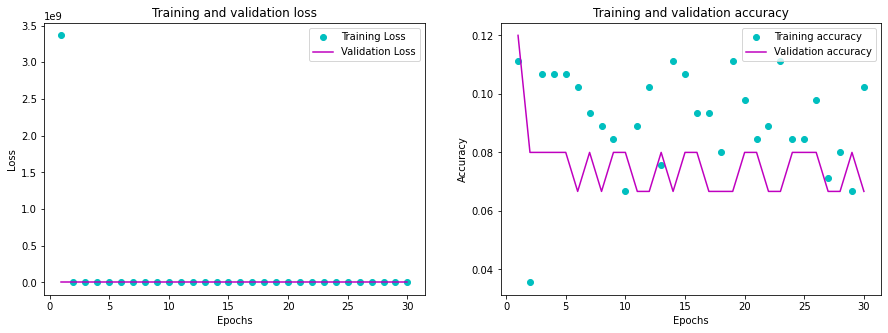

In [37]:
#Adapted from Deep Learning with Python by Francois Chollet, 2018
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [38]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 69ms/step - loss: 2.3051 - accuracy: 0.1000
Confusion_matrix:  tf.Tensor(
[[ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]], shape=(10, 10), dtype=int32)


In [39]:
model.save("model/VGG16/fit-adam-VGG16-0.01.h5")

# Intento 3 

In [40]:
baseModel = VGG16(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/VGG16/base-adam-VGG16-0.001.h5")

In [41]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [42]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 4s 150ms/step - loss: 3.2313 - accuracy: 0.1226 - val_loss: 2.3027 - val_accuracy: 0.1067
Epoch 2/30
23/23 [==============================] - 3s 141ms/step - loss: 2.3018 - accuracy: 0.1363 - val_loss: 2.3059 - val_accuracy: 0.0800
Epoch 3/30
23/23 [==============================] - 3s 142ms/step - loss: 2.3037 - accuracy: 0.0899 - val_loss: 2.3074 - val_accuracy: 0.0800
Epoch 4/30
23/23 [==============================] - 3s 141ms/step - loss: 2.3012 - accuracy: 0.1052 - val_loss: 2.3110 - val_accuracy: 0.0800
Epoch 5/30
23/23 [==============================] - 3s 141ms/step - loss: 2.2960 - accuracy: 0.1312 - val_loss: 2.3127 - val_accuracy: 0.0800
Epoch 6/30
23/23 [==============================] - 3s 141ms/step - loss: 2.3001 - accuracy: 0.0792 - val_loss: 2.3132 - val_accuracy: 0.0667
Epoch 7/30
23/23 [==============================] - 3s 141ms/step - loss: 2.3024 - accuracy: 0.0952 - val_loss: 2.3145 - val_accuracy: 0.0800
Epoch 

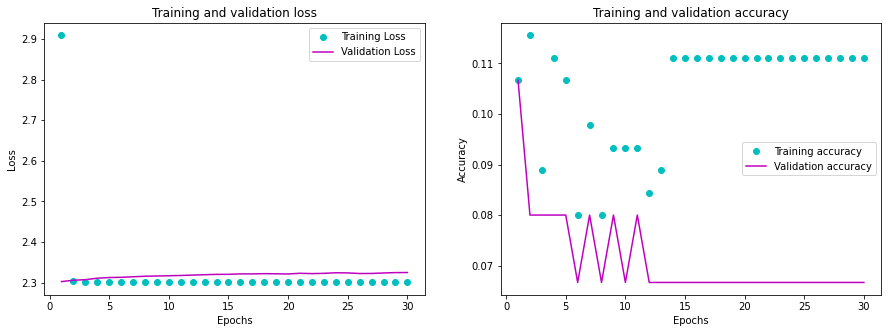

In [43]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [44]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 69ms/step - loss: 2.3059 - accuracy: 0.1000
Confusion_matrix:  tf.Tensor(
[[ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]], shape=(10, 10), dtype=int32)


In [45]:
model.save("model/VGG16/fit-adam-VGG16-0.001.h5")

# intento 4

In [46]:
baseModel = VGG16(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/VGG16/base-adam-VGG16-0.0001.h5")

In [47]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [48]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 4s 150ms/step - loss: 2.4605 - accuracy: 0.0921 - val_loss: 2.5754 - val_accuracy: 0.0800
Epoch 2/30
23/23 [==============================] - 3s 143ms/step - loss: 2.3449 - accuracy: 0.0813 - val_loss: 2.3102 - val_accuracy: 0.0800
Epoch 3/30
23/23 [==============================] - 3s 143ms/step - loss: 2.3146 - accuracy: 0.1098 - val_loss: 2.3052 - val_accuracy: 0.0800
Epoch 4/30
23/23 [==============================] - 3s 143ms/step - loss: 2.3058 - accuracy: 0.0973 - val_loss: 2.3047 - val_accuracy: 0.0800
Epoch 5/30
23/23 [==============================] - 3s 142ms/step - loss: 2.3024 - accuracy: 0.1140 - val_loss: 2.3032 - val_accuracy: 0.0800
Epoch 6/30
23/23 [==============================] - 3s 142ms/step - loss: 2.3029 - accuracy: 0.1070 - val_loss: 2.3034 - val_accuracy: 0.0800
Epoch 7/30
23/23 [==============================] - 3s 142ms/step - loss: 2.3023 - accuracy: 0.1038 - val_loss: 2.3037 - val_accuracy: 0.0800
Epoch 

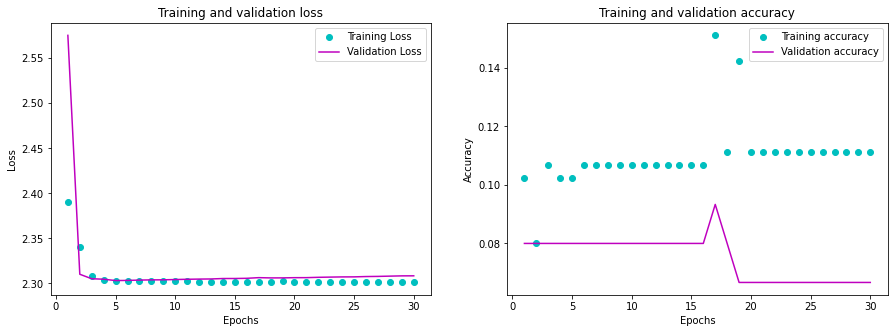

In [49]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [50]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 70ms/step - loss: 2.3029 - accuracy: 0.1000
Confusion_matrix:  tf.Tensor(
[[ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]], shape=(10, 10), dtype=int32)


In [51]:
model.save("model/VGG16/fit-adam-VGG16-0.0001.h5")

# intento 5

In [52]:
baseModel = VGG16(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/VGG16/base-adam-VGG16-0.00001.h5")

In [53]:
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [54]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 4s 152ms/step - loss: 2.3451 - accuracy: 0.1296 - val_loss: 2.1781 - val_accuracy: 0.0933
Epoch 2/30
23/23 [==============================] - 3s 144ms/step - loss: 2.0591 - accuracy: 0.2229 - val_loss: 1.9876 - val_accuracy: 0.3467
Epoch 3/30
23/23 [==============================] - 3s 148ms/step - loss: 1.7753 - accuracy: 0.3977 - val_loss: 1.8089 - val_accuracy: 0.3733
Epoch 4/30
23/23 [==============================] - 3s 149ms/step - loss: 1.6312 - accuracy: 0.4819 - val_loss: 1.5981 - val_accuracy: 0.4533
Epoch 5/30
23/23 [==============================] - 3s 147ms/step - loss: 1.2163 - accuracy: 0.5882 - val_loss: 1.5378 - val_accuracy: 0.4533
Epoch 6/30
23/23 [==============================] - 3s 148ms/step - loss: 1.1577 - accuracy: 0.6422 - val_loss: 1.5217 - val_accuracy: 0.4400
Epoch 7/30
23/23 [==============================] - 3s 149ms/step - loss: 0.9260 - accuracy: 0.7242 - val_loss: 1.3168 - val_accuracy: 0.5867
Epoch 

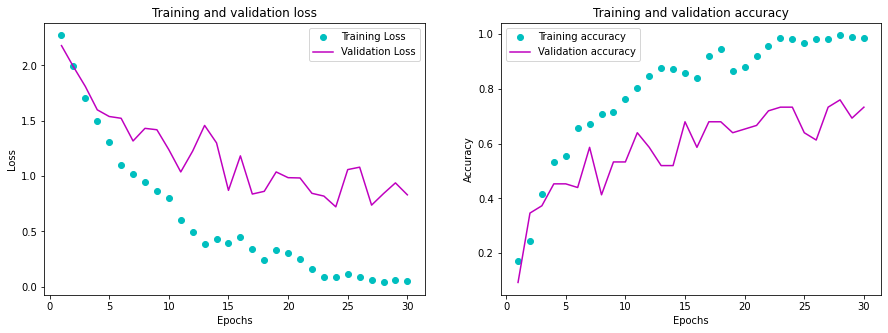

In [55]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [56]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 68ms/step - loss: 0.8638 - accuracy: 0.7700
Confusion_matrix:  tf.Tensor(
[[ 8  0  0  0  0  2  0  0  0  0]
 [ 2  8  0  0  0  0  0  0  0  0]
 [ 0  0  9  0  0  0  0  1  0  0]
 [ 2  0  0  6  0  1  0  0  1  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 3  0  0  0  0  6  0  0  1  0]
 [ 0  0  0  0  0  1  9  0  0  0]
 [ 0  0  0  4  0  0  0  6  0  0]
 [ 0  0  0  0  0  0  0  0 10  0]
 [ 2  1  0  0  0  2  0  0  0  5]], shape=(10, 10), dtype=int32)


In [57]:
model.save("model/VGG16/fit-adam-VGG16-0.00001.h5")

# cambio de SGD

# INTENTO 1

In [58]:
baseModel = VGG16(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/VGG16/base-SGD-VGG16-0.1.h5")

In [59]:
opt = tf.keras.optimizers.SGD(learning_rate=0.1)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [60]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 4s 147ms/step - loss: nan - accuracy: 0.1228 - val_loss: nan - val_accuracy: 0.0800
Epoch 2/30
23/23 [==============================] - 3s 139ms/step - loss: nan - accuracy: 0.0980 - val_loss: nan - val_accuracy: 0.0800
Epoch 3/30
23/23 [==============================] - 3s 139ms/step - loss: nan - accuracy: 0.0874 - val_loss: nan - val_accuracy: 0.0800
Epoch 4/30
23/23 [==============================] - 3s 139ms/step - loss: nan - accuracy: 0.0881 - val_loss: nan - val_accuracy: 0.0800
Epoch 5/30
23/23 [==============================] - 3s 139ms/step - loss: nan - accuracy: 0.1358 - val_loss: nan - val_accuracy: 0.0800
Epoch 6/30
23/23 [==============================] - 3s 142ms/step - loss: nan - accuracy: 0.1280 - val_loss: nan - val_accuracy: 0.0800
Epoch 7/30
23/23 [==============================] - 3s 144ms/step - loss: nan - accuracy: 0.1130 - val_loss: nan - val_accuracy: 0.0800
Epoch 8/30
23/23 [==============================

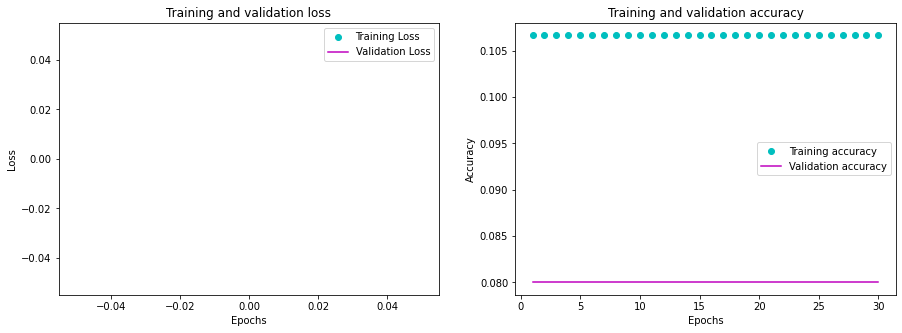

In [61]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [62]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 68ms/step - loss: nan - accuracy: 0.1000
Confusion_matrix:  tf.Tensor(
[[10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]], shape=(10, 10), dtype=int32)


In [63]:
model.save("model/VGG16/fit-SGD-VGG16-0.1.h5")

# INTENTO 2

In [64]:
baseModel = VGG16(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/VGG16/base-SGD-VGG16-0.01.h5")

In [65]:
opt = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [66]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 4s 148ms/step - loss: nan - accuracy: 0.0845 - val_loss: nan - val_accuracy: 0.0800
Epoch 2/30
23/23 [==============================] - 3s 138ms/step - loss: nan - accuracy: 0.1278 - val_loss: nan - val_accuracy: 0.0800
Epoch 3/30
23/23 [==============================] - 3s 138ms/step - loss: nan - accuracy: 0.1036 - val_loss: nan - val_accuracy: 0.0800
Epoch 4/30
23/23 [==============================] - 3s 138ms/step - loss: nan - accuracy: 0.0817 - val_loss: nan - val_accuracy: 0.0800
Epoch 5/30
23/23 [==============================] - 3s 138ms/step - loss: nan - accuracy: 0.0986 - val_loss: nan - val_accuracy: 0.0800
Epoch 6/30
23/23 [==============================] - 3s 138ms/step - loss: nan - accuracy: 0.1151 - val_loss: nan - val_accuracy: 0.0800
Epoch 7/30
23/23 [==============================] - 3s 138ms/step - loss: nan - accuracy: 0.0947 - val_loss: nan - val_accuracy: 0.0800
Epoch 8/30
23/23 [==============================

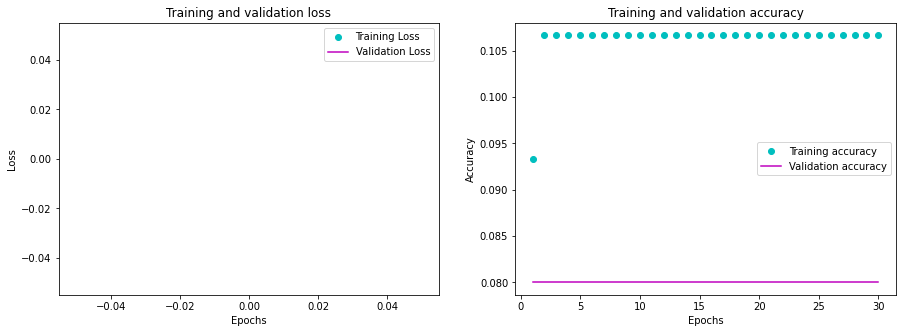

In [67]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [68]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 68ms/step - loss: nan - accuracy: 0.1000
Confusion_matrix:  tf.Tensor(
[[10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]], shape=(10, 10), dtype=int32)


In [69]:
model.save("model/VGG16/fit-SGD-VGG16-0.01.h5")

# INTENTO 3

In [70]:
baseModel = VGG16(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/VGG16/base-SGD-VGG16-0.001.h5")

In [71]:
opt = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [72]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 4s 150ms/step - loss: 2.4537 - accuracy: 0.0999 - val_loss: 2.2834 - val_accuracy: 0.1067
Epoch 2/30
23/23 [==============================] - 3s 140ms/step - loss: 2.2864 - accuracy: 0.1042 - val_loss: 2.3057 - val_accuracy: 0.1067
Epoch 3/30
23/23 [==============================] - 3s 142ms/step - loss: 2.2352 - accuracy: 0.1513 - val_loss: 2.2982 - val_accuracy: 0.0933
Epoch 4/30
23/23 [==============================] - 3s 140ms/step - loss: 2.1758 - accuracy: 0.2056 - val_loss: 2.1690 - val_accuracy: 0.2667
Epoch 5/30
23/23 [==============================] - 3s 141ms/step - loss: 2.1067 - accuracy: 0.2524 - val_loss: 2.4312 - val_accuracy: 0.1467
Epoch 6/30
23/23 [==============================] - 3s 141ms/step - loss: 2.2011 - accuracy: 0.1491 - val_loss: 2.1796 - val_accuracy: 0.1600
Epoch 7/30
23/23 [==============================] - 3s 141ms/step - loss: 1.9689 - accuracy: 0.2365 - val_loss: 2.1083 - val_accuracy: 0.2000
Epoch 

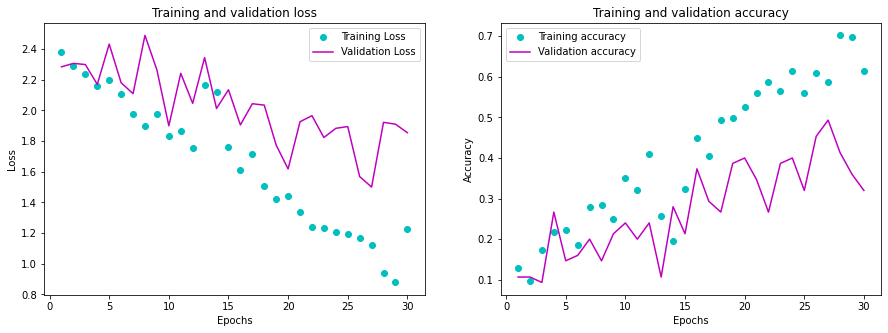

In [73]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [74]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 68ms/step - loss: 1.4702 - accuracy: 0.5100
Confusion_matrix:  tf.Tensor(
[[10  0  0  0  0  0  0  0  0  0]
 [ 2  7  0  0  0  0  0  0  0  1]
 [ 4  0  6  0  0  0  0  0  0  0]
 [ 3  0  0  2  0  0  0  0  5  0]
 [ 1  0  0  0  9  0  0  0  0  0]
 [ 6  0  0  0  0  1  0  0  3  0]
 [ 6  0  0  0  0  1  3  0  0  0]
 [ 5  0  0  3  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  0  0 10  0]
 [ 7  1  0  0  0  1  0  0  0  1]], shape=(10, 10), dtype=int32)


In [75]:
model.save("model/VGG16/fit-SGD-VGG16-0.001.h5")

# INTENTO 4

In [76]:
baseModel = VGG16(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/VGG16/base-SGD-VGG16-0.0001.h5")

In [77]:
opt = tf.keras.optimizers.SGD(learning_rate=0.0001)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [78]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 4s 150ms/step - loss: 2.6239 - accuracy: 0.0638 - val_loss: 2.4972 - val_accuracy: 0.1067
Epoch 2/30
23/23 [==============================] - 3s 141ms/step - loss: 2.3966 - accuracy: 0.1135 - val_loss: 2.3930 - val_accuracy: 0.1467
Epoch 3/30
23/23 [==============================] - 3s 142ms/step - loss: 2.3556 - accuracy: 0.1538 - val_loss: 2.3409 - val_accuracy: 0.0933
Epoch 4/30
23/23 [==============================] - 3s 141ms/step - loss: 2.3055 - accuracy: 0.1336 - val_loss: 2.3127 - val_accuracy: 0.0933
Epoch 5/30
23/23 [==============================] - 3s 141ms/step - loss: 2.2823 - accuracy: 0.1682 - val_loss: 2.2762 - val_accuracy: 0.1867
Epoch 6/30
23/23 [==============================] - 3s 141ms/step - loss: 2.2492 - accuracy: 0.1771 - val_loss: 2.2917 - val_accuracy: 0.1067
Epoch 7/30
23/23 [==============================] - 3s 141ms/step - loss: 2.2481 - accuracy: 0.1635 - val_loss: 2.2588 - val_accuracy: 0.1733
Epoch 

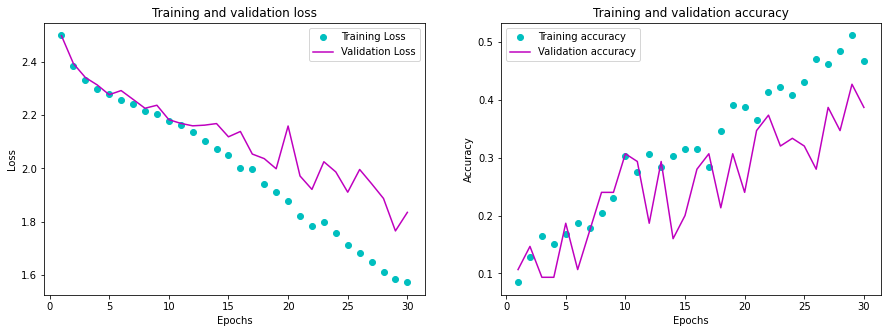

In [79]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [80]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 70ms/step - loss: 1.6469 - accuracy: 0.4700
Confusion_matrix:  tf.Tensor(
[[ 1  2  2  0  3  0  2  0  0  0]
 [ 0  7  2  0  0  1  0  0  0  0]
 [ 0  0  9  0  0  0  0  0  1  0]
 [ 1  0  0  0  0  0  0  0  7  2]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0  0  0  4  0  6  0]
 [ 0  2  2  0  0  1  5  0  0  0]
 [ 0  1  3  2  0  0  0  1  3  0]
 [ 0  0  0  0  0  0  0  0 10  0]
 [ 0  3  0  0  1  0  1  0  1  4]], shape=(10, 10), dtype=int32)


In [81]:
model.save("model/VGG16/fit-SGD-VGG16-0.0001.h5")

# INTENTO 5

In [82]:
baseModel = VGG16(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/VGG16/base-SGD-VGG16-0.00001.h5")

In [83]:
opt = tf.keras.optimizers.SGD(learning_rate=0.00001)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [84]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 4s 152ms/step - loss: 2.6909 - accuracy: 0.0979 - val_loss: 2.6898 - val_accuracy: 0.1067
Epoch 2/30
23/23 [==============================] - 3s 145ms/step - loss: 2.5349 - accuracy: 0.1163 - val_loss: 2.6487 - val_accuracy: 0.1067
Epoch 3/30
23/23 [==============================] - 3s 146ms/step - loss: 2.6060 - accuracy: 0.1111 - val_loss: 2.6180 - val_accuracy: 0.1067
Epoch 4/30
23/23 [==============================] - 3s 141ms/step - loss: 2.5132 - accuracy: 0.1141 - val_loss: 2.5934 - val_accuracy: 0.1067
Epoch 5/30
23/23 [==============================] - 3s 141ms/step - loss: 2.5044 - accuracy: 0.1082 - val_loss: 2.5719 - val_accuracy: 0.1067
Epoch 6/30
23/23 [==============================] - 3s 141ms/step - loss: 2.4735 - accuracy: 0.1148 - val_loss: 2.5525 - val_accuracy: 0.1067
Epoch 7/30
23/23 [==============================] - 3s 142ms/step - loss: 2.4597 - accuracy: 0.1144 - val_loss: 2.5355 - val_accuracy: 0.1067
Epoch 

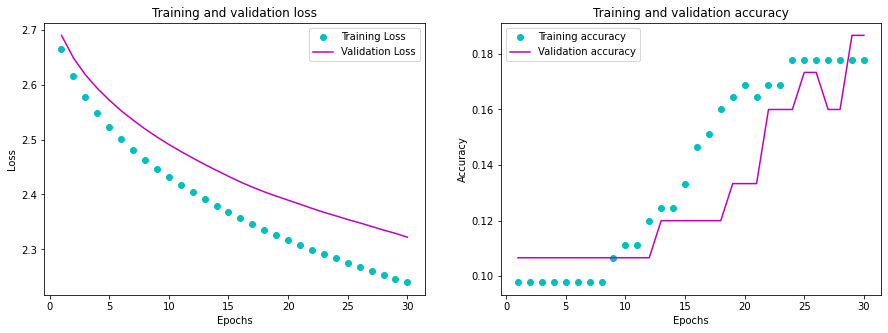

In [85]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [86]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 69ms/step - loss: 2.2652 - accuracy: 0.1800
Confusion_matrix:  tf.Tensor(
[[ 0  0  0  0  7  0  3  0  0  0]
 [ 0  0  0  0  9  0  1  0  0  0]
 [ 0  0  0  0  6  0  4  0  0  0]
 [ 0  0  0  0  3  0  7  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0  0  0 10  0  0  0]
 [ 0  0  0  0  2  0  8  0  0  0]
 [ 0  0  0  0  4  0  6  0  0  0]
 [ 0  0  0  0  0  0 10  0  0  0]
 [ 0  0  0  0  3  0  7  0  0  0]], shape=(10, 10), dtype=int32)


In [87]:
model.save("model/VGG16/fit-SGD-VGG16-0.00001.h5")

# Cambio a Adamax

# intento 1

In [88]:
baseModel = VGG16(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/VGG16/base-Adamax-VGG16-0.1.h5")

In [89]:
opt = tf.keras.optimizers.Adamax(learning_rate=0.1)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [90]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 4s 149ms/step - loss: 34888285183130340425728.0000 - accuracy: 0.1245 - val_loss: 1968469442560.0000 - val_accuracy: 0.0800
Epoch 2/30
23/23 [==============================] - 3s 142ms/step - loss: 328925941760.0000 - accuracy: 0.1479 - val_loss: 70569016.0000 - val_accuracy: 0.0800
Epoch 3/30
23/23 [==============================] - 3s 141ms/step - loss: 46028116.1667 - accuracy: 0.1441 - val_loss: 1605122.1250 - val_accuracy: 0.1067
Epoch 4/30
23/23 [==============================] - 3s 141ms/step - loss: 1272688.9557 - accuracy: 0.1018 - val_loss: 417616.1562 - val_accuracy: 0.0800
Epoch 5/30
23/23 [==============================] - 3s 143ms/step - loss: 253488.1986 - accuracy: 0.1283 - val_loss: 3961.2942 - val_accuracy: 0.0800
Epoch 6/30
23/23 [==============================] - 3s 141ms/step - loss: 1048.0945 - accuracy: 0.1044 - val_loss: 5.4789 - val_accuracy: 0.1200
Epoch 7/30
23/23 [==============================] - 3s 140ms/

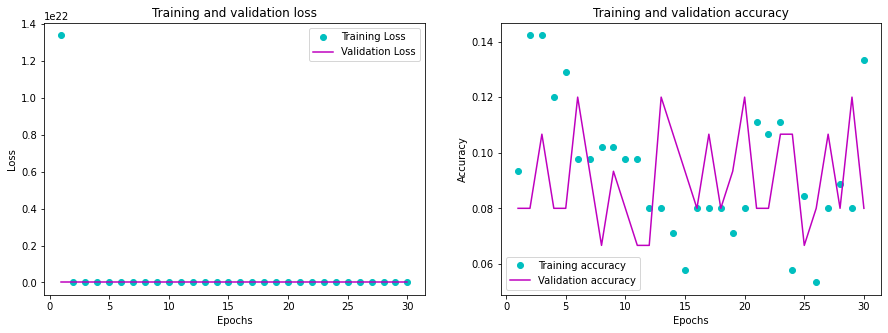

In [91]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [92]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 68ms/step - loss: 2.3489 - accuracy: 0.1000
Confusion_matrix:  tf.Tensor(
[[ 0 10  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]], shape=(10, 10), dtype=int32)


In [93]:
model.save("model/VGG16/fit-Adamax-VGG16-0.1.h5")

# intento 2

In [94]:
baseModel = VGG16(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/VGG16/base-Adamax-VGG16-0.01.h5")

In [95]:
opt = tf.keras.optimizers.Adamax(learning_rate=0.01)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [96]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 4s 149ms/step - loss: 14787235818.7789 - accuracy: 0.1319 - val_loss: 2.3076 - val_accuracy: 0.1200
Epoch 2/30
23/23 [==============================] - 3s 141ms/step - loss: 2.3850 - accuracy: 0.1036 - val_loss: 2.3475 - val_accuracy: 0.1067
Epoch 3/30
23/23 [==============================] - 3s 141ms/step - loss: 2.3153 - accuracy: 0.1144 - val_loss: 2.3309 - val_accuracy: 0.0933
Epoch 4/30
23/23 [==============================] - 3s 141ms/step - loss: 2.3132 - accuracy: 0.0859 - val_loss: 2.3161 - val_accuracy: 0.0667
Epoch 5/30
23/23 [==============================] - 3s 141ms/step - loss: 2.2954 - accuracy: 0.1225 - val_loss: 2.3187 - val_accuracy: 0.0667
Epoch 6/30
23/23 [==============================] - 3s 141ms/step - loss: 2.3000 - accuracy: 0.0931 - val_loss: 2.3164 - val_accuracy: 0.0800
Epoch 7/30
23/23 [==============================] - 3s 141ms/step - loss: 2.3018 - accuracy: 0.0927 - val_loss: 2.3220 - val_accuracy: 0.0

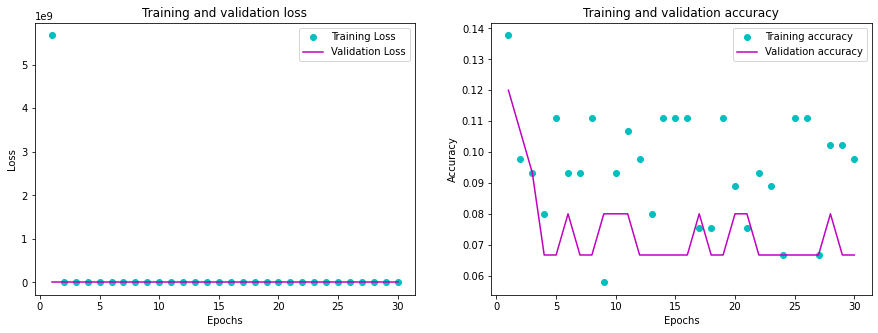

In [97]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [98]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 73ms/step - loss: 2.3054 - accuracy: 0.1000
Confusion_matrix:  tf.Tensor(
[[ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]], shape=(10, 10), dtype=int32)


In [99]:
model.save("model/VGG16/fit-Adamax-VGG16-0.01.h5")

# intento 3

In [100]:
baseModel = VGG16(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/VGG16/base-Adamax-VGG16-0.001.h5")

In [101]:
opt = tf.keras.optimizers.Adamax(learning_rate=0.001)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [102]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 4s 152ms/step - loss: 6.5369 - accuracy: 0.0539 - val_loss: 2.3044 - val_accuracy: 0.0800
Epoch 2/30
23/23 [==============================] - 3s 150ms/step - loss: 2.3026 - accuracy: 0.0679 - val_loss: 2.3051 - val_accuracy: 0.0800
Epoch 3/30
23/23 [==============================] - 3s 148ms/step - loss: 2.3014 - accuracy: 0.0748 - val_loss: 2.3059 - val_accuracy: 0.0800
Epoch 4/30
23/23 [==============================] - 3s 145ms/step - loss: 2.3028 - accuracy: 0.0826 - val_loss: 2.3062 - val_accuracy: 0.0667
Epoch 5/30
23/23 [==============================] - 3s 146ms/step - loss: 2.3011 - accuracy: 0.1279 - val_loss: 2.3073 - val_accuracy: 0.0667
Epoch 6/30
23/23 [==============================] - 3s 150ms/step - loss: 2.3004 - accuracy: 0.1304 - val_loss: 2.3076 - val_accuracy: 0.0667
Epoch 7/30
23/23 [==============================] - 3s 145ms/step - loss: 2.2997 - accuracy: 0.0958 - val_loss: 2.3081 - val_accuracy: 0.0667
Epoch 

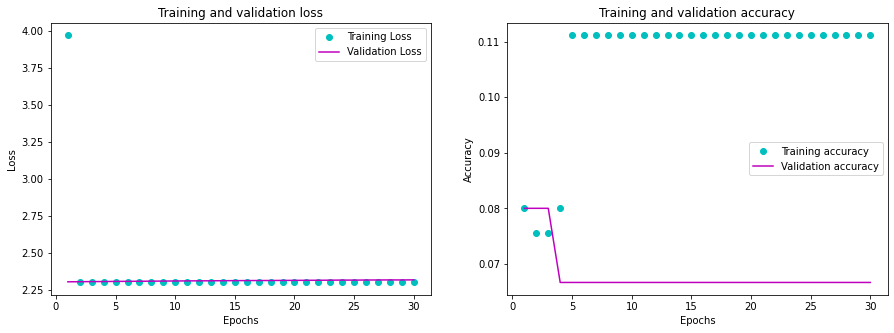

In [103]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [104]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 68ms/step - loss: 2.3042 - accuracy: 0.1000
Confusion_matrix:  tf.Tensor(
[[ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]], shape=(10, 10), dtype=int32)


In [105]:
model.save("model/VGG16/fit-Adamax-VGG16-0.001.h5")

# intento 4

In [106]:
baseModel = VGG16(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/VGG16/base-Adamax-VGG16-0.0001.h5")

In [107]:
opt = tf.keras.optimizers.Adamax(learning_rate=0.0001)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [108]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 4s 149ms/step - loss: 2.3874 - accuracy: 0.1238 - val_loss: 2.3099 - val_accuracy: 0.0933
Epoch 2/30
23/23 [==============================] - 3s 141ms/step - loss: 2.3123 - accuracy: 0.1024 - val_loss: 2.3057 - val_accuracy: 0.1200
Epoch 3/30
23/23 [==============================] - 3s 141ms/step - loss: 2.2960 - accuracy: 0.1159 - val_loss: 2.3099 - val_accuracy: 0.0800
Epoch 4/30
23/23 [==============================] - 3s 141ms/step - loss: 2.2979 - accuracy: 0.1159 - val_loss: 2.2938 - val_accuracy: 0.1733
Epoch 5/30
23/23 [==============================] - 3s 141ms/step - loss: 2.2846 - accuracy: 0.1076 - val_loss: 2.2746 - val_accuracy: 0.1333
Epoch 6/30
23/23 [==============================] - 3s 141ms/step - loss: 2.2548 - accuracy: 0.1188 - val_loss: 2.1952 - val_accuracy: 0.2400
Epoch 7/30
23/23 [==============================] - 3s 141ms/step - loss: 2.1359 - accuracy: 0.1803 - val_loss: 2.0474 - val_accuracy: 0.2267
Epoch 

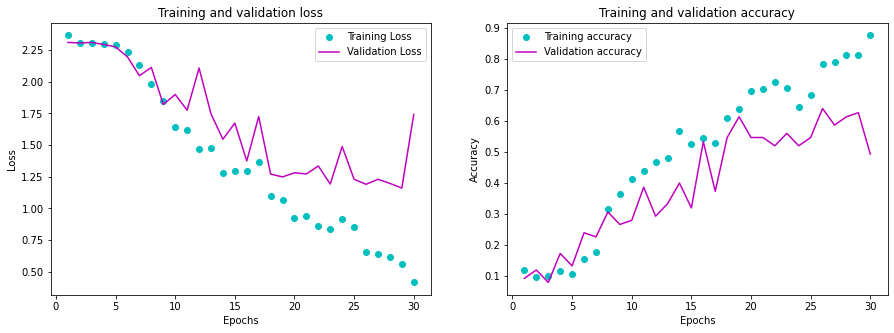

In [109]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [110]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 70ms/step - loss: 1.5302 - accuracy: 0.5400
Confusion_matrix:  tf.Tensor(
[[ 4  0  0  0  1  0  0  0  0  5]
 [ 0  6  0  0  1  0  0  0  0  3]
 [ 2  0  6  0  0  1  1  0  0  0]
 [ 3  0  0  1  3  0  0  0  3  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 2  0  0  0  1  2  0  0  1  4]
 [ 2  3  0  0  0  0  2  0  0  3]
 [ 3  0  0  0  1  0  0  5  0  1]
 [ 0  0  0  0  0  0  0  0 10  0]
 [ 0  1  0  0  1  0  0  0  0  8]], shape=(10, 10), dtype=int32)


In [111]:
model.save("model/VGG16/fit-Adamax-VGG16-0.0001.h5")

# intento 5

In [112]:
baseModel = VGG16(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/VGG16/base-Adamax-VGG16-0.00001.h5")

In [113]:
opt = tf.keras.optimizers.Adamax(learning_rate=0.00001)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [114]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 4s 154ms/step - loss: 2.3444 - accuracy: 0.0997 - val_loss: 2.2633 - val_accuracy: 0.1467
Epoch 2/30
23/23 [==============================] - 3s 145ms/step - loss: 2.1778 - accuracy: 0.1934 - val_loss: 2.1612 - val_accuracy: 0.2667
Epoch 3/30
23/23 [==============================] - 3s 144ms/step - loss: 2.0778 - accuracy: 0.3060 - val_loss: 2.0424 - val_accuracy: 0.2667
Epoch 4/30
23/23 [==============================] - 3s 143ms/step - loss: 1.9049 - accuracy: 0.3167 - val_loss: 2.0109 - val_accuracy: 0.2933
Epoch 5/30
23/23 [==============================] - 3s 143ms/step - loss: 1.8297 - accuracy: 0.3559 - val_loss: 1.9828 - val_accuracy: 0.3067
Epoch 6/30
23/23 [==============================] - 3s 143ms/step - loss: 1.7523 - accuracy: 0.4305 - val_loss: 2.0405 - val_accuracy: 0.3333
Epoch 7/30
23/23 [==============================] - 3s 143ms/step - loss: 1.6607 - accuracy: 0.4922 - val_loss: 1.8935 - val_accuracy: 0.4267
Epoch 

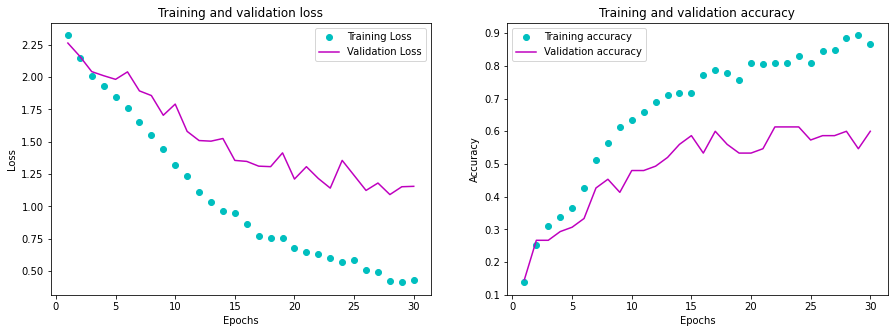

In [115]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [116]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 71ms/step - loss: 0.9775 - accuracy: 0.7000
Confusion_matrix:  tf.Tensor(
[[ 6  0  0  0  1  0  2  1  0  0]
 [ 1  9  0  0  0  0  0  0  0  0]
 [ 0  0  9  0  0  1  0  0  0  0]
 [ 2  0  0  7  0  0  0  0  1  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 3  0  0  0  1  5  0  1  0  0]
 [ 1  3  0  0  0  1  5  0  0  0]
 [ 0  0  1  1  1  0  0  7  0  0]
 [ 1  0  0  0  0  0  0  0  9  0]
 [ 1  2  0  0  1  2  1  0  0  3]], shape=(10, 10), dtype=int32)


In [117]:
model.save("model/VGG16/fit-Adamax-VGG16-0.00001.h5")